In [2]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 4.4 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 19.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 14.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 27.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 10.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [1]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

ModuleNotFoundError: No module named 'torch'

In [21]:
import pandas as pd
inflow = pd.read_parquet('Week 2/q1-ucsd-inflows.pqt')
outflow = pd.read_parquet('Week 2/q1-ucsd-outflows.pqt')

outflow_ids = set(outflow["prism_consumer_id"].unique())
inflow_ids = set(inflow["prism_consumer_id"].unique())

# Consumers in inflow but not in outflow
in_not_out = inflow_ids - outflow_ids
out_not_in = outflow_ids - inflow_ids
#consumers in both inflow and outflow
consumers_both = sorted(set(inflow["prism_consumer_id"]).intersection(outflow["prism_consumer_id"]))

#80-20 train test split
train_ids, test_ids = train_test_split(consumers_both, test_size=0.2, random_state=42)

inflow_train = inflow[inflow["prism_consumer_id"].isin(train_ids)]
inflow_test  = inflow[inflow["prism_consumer_id"].isin(test_ids)]

outflow_train = outflow[outflow["prism_consumer_id"].isin(train_ids)]
outflow_test  = outflow[outflow["prism_consumer_id"].isin(test_ids)]


In [22]:
df = outflow_train.copy()
df = df[df["memo"] != df["category"]]
df["posted_date"] = pd.to_datetime(df["posted_date"])
posted = df["posted_date"]

df["dow"]   = posted.dt.weekday          # 0–6
df["month"] = posted.dt.month           # 1–12

# cyclical encodings
df["dow_sin"]   = np.sin(2 * np.pi * df["dow"]   / 7)
df["dow_cos"]   = np.cos(2 * np.pi * df["dow"]   / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
amount_train = df["amount"].astype("float32")
amount_mean = amount_train.mean()
amount_std  = amount_train.std() + 1e-8
df["amount_z"] = (amount_train - amount_train.mean()) / (amount_train.std() + 1e-8)
extra_cols = ["amount_z", "dow_sin", "dow_cos", "month_sin", "month_cos"]
extra_feats = df[extra_cols].to_numpy(dtype=np.float32)   # shape [N, 5]

# Make category dtype and get integer codes
df["category_code"] = df["category"].astype("category").cat.codes

labels = df["category_code"].to_numpy(dtype=np.int64)

# Optional: store mapping for later interpretation
cat_categories = df["category"].astype("category").cat.categories
id2cat = dict(enumerate(cat_categories))
cat2id = {v: k for k, v in id2cat.items()}

print(id2cat)
# e.g. {0: 'EDUCATION', 1: 'FOOD_AND_BEVERAGES', ...}
memos  = df["memo"].tolist()

{0: 'EDUCATION', 1: 'FOOD_AND_BEVERAGES', 2: 'GENERAL_MERCHANDISE', 3: 'GROCERIES', 4: 'MORTGAGE', 5: 'OVERDRAFT', 6: 'PETS', 7: 'RENT', 8: 'TRAVEL'}


In [23]:
device = torch.device("cuda")

In [24]:
df["memo"].apply(lambda x: len(str(x).split())).sort_values()

665         1
666         1
671         1
686         1
690         1
           ..
534265     33
535010     33
534994     33
534504     33
2113388    37
Name: memo, Length: 1044281, dtype: int64

In [25]:
lengths = df["memo"].apply(lambda x: len(str(x).split()))

print(lengths.describe())
print(np.percentile(lengths, [50, 75, 90, 95, 99.5]))

count    1.044281e+06
mean     5.944968e+00
std      4.469744e+00
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      3.700000e+01
Name: memo, dtype: float64
[ 5. 10. 12. 13. 18.]


In [26]:
import re
from collections import Counter

def basic_tokenize(text):
    text = str(text).lower()
    # very simple: split on non-alphanumeric characters
    tokens = re.findall(r"[a-z0-9]+", text)
    return tokens

def build_vocab(texts, min_freq=2, max_size=20000):
    counter = Counter()
    for t in texts:
        counter.update(basic_tokenize(t))

    # special tokens
    itos = ["<PAD>", "<UNK>"]  # index 0, 1
    for tok, freq in counter.most_common():
        if freq < min_freq:
            break
        if len(itos) >= max_size:
            break
        itos.append(tok)

    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos

# 1) build vocab from all memos
vocab, itos = build_vocab(memos, min_freq=2, max_size=20000)
pad_idx = vocab["<PAD>"]
unk_idx = vocab["<UNK>"]

def encode(text, vocab, max_len=17):
    tokens = basic_tokenize(text)
    ids = [vocab.get(tok, unk_idx) for tok in tokens][:max_len]
    # pad if shorter than max_len
    if len(ids) < max_len:
        ids += [pad_idx] * (max_len - len(ids))
    return ids

In [27]:
X_tokens = np.array([encode(m, vocab) for m in memos], dtype=np.int64)

In [28]:
from sklearn.model_selection import train_test_split

X_tok_train, X_tok_val, X_extra_train, X_extra_val, y_train, y_val = train_test_split(
    X_tokens,
    extra_feats,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [29]:
class MemoPlusDataset(data.Dataset):
    def __init__(self, X_tokens, X_extra, y):
        self.X_tokens = torch.from_numpy(X_tokens)  # [N, max_len], long
        self.X_extra  = torch.from_numpy(X_extra)   # [N, num_extra], float
        self.y        = torch.from_numpy(y)         # [N]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_tokens[idx], self.X_extra[idx], self.y[idx]

train_ds = MemoPlusDataset(X_tok_train, X_extra_train, y_train)
val_ds   = MemoPlusDataset(X_tok_val,   X_extra_val,   y_val)

train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = data.DataLoader(val_ds,   batch_size=256, shuffle=False)

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [batch, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

In [31]:
class MemoMultiInputTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        num_extra_features,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        pad_idx=0,
        max_len=128,
        dropout=0.1,
    ):
        super().__init__()
        self.pad_idx = pad_idx
        self.d_model = d_model

        # ---- Text branch ----
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # so inputs are [B, S, D]
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # ---- Numeric branch (amount + date) ----
        self.extra_mlp = nn.Sequential(
            nn.Linear(num_extra_features, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # ---- Classifier on concatenated features ----
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(2 * d_model, num_classes)

    def forward(self, x_tokens, x_extra):
        """
        x_tokens: [batch, seq_len]  (long)
        x_extra:  [batch, num_extra_features] (float)
        """
        # Text branch
        src = self.embedding(x_tokens) * math.sqrt(self.d_model)  # [B, S, D]
        src = self.pos_encoder(src)

        # key_padding_mask: True for PAD positions
        src_key_padding_mask = (x_tokens == self.pad_idx)         # [B, S]

        encoded = self.transformer_encoder(
            src,
            src_key_padding_mask=src_key_padding_mask
        )  # [B, S, D]

        # Mean pool over non-PAD tokens
        mask = (~src_key_padding_mask).unsqueeze(-1)              # [B, S, 1]
        summed = (encoded * mask).sum(dim=1)                      # [B, D]
        counts = mask.sum(dim=1).clamp(min=1)                     # [B, 1]
        text_repr = summed / counts                               # [B, D]

        # Numeric branch
        extra_repr = self.extra_mlp(x_extra)                      # [B, D]

        # Concatenate & classify
        combined = torch.cat([text_repr, extra_repr], dim=1)      # [B, 2D]
        combined = self.dropout(combined)
        logits = self.fc_out(combined)                            # [B, num_classes]
        return logits

In [32]:

num_classes = len(np.unique(labels))
num_extra_features = len(extra_cols)  # 5 in our example

model = MemoMultiInputTransformer(
    vocab_size=len(itos),
    num_classes=num_classes,
    num_extra_features=num_extra_features,
    pad_idx=pad_idx,
    max_len=37,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [38]:
def accuracy(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()

for epoch in range(10):
    # ---- train ----
    model.train()
    train_loss = train_acc = 0.0
    n_batches = 0

    for X_tok, X_extra, y_batch in train_loader:
        X_tok   = X_tok.to(device)
        X_extra = X_extra.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_tok, X_extra)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc  += accuracy(logits.detach(), y_batch)
        n_batches  += 1

    train_loss /= n_batches
    train_acc  /= n_batches

    # ---- validation ----
    model.eval()
    val_loss = val_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for X_tok, X_extra, y_batch in val_loader:
            X_tok   = X_tok.to(device)
            X_extra = X_extra.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_tok, X_extra)
            loss = criterion(logits, y_batch)

            val_loss += loss.item()
            val_acc  += accuracy(logits, y_batch)
            n_batches += 1

    val_loss /= n_batches
    val_acc  /= n_batches

    print(f"Epoch {epoch+1}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

Epoch 1: train_loss=0.1740, train_acc=0.9418, val_loss=0.0895, val_acc=0.9712
Epoch 2: train_loss=0.0823, train_acc=0.9731, val_loss=0.0708, val_acc=0.9778
Epoch 3: train_loss=0.0648, train_acc=0.9789, val_loss=0.0602, val_acc=0.9810
Epoch 4: train_loss=0.0561, train_acc=0.9820, val_loss=0.0555, val_acc=0.9827
Epoch 5: train_loss=0.0502, train_acc=0.9837, val_loss=0.0535, val_acc=0.9838
Epoch 6: train_loss=0.0462, train_acc=0.9849, val_loss=0.0497, val_acc=0.9846
Epoch 7: train_loss=0.0431, train_acc=0.9857, val_loss=0.0476, val_acc=0.9856
Epoch 8: train_loss=0.0404, train_acc=0.9868, val_loss=0.0501, val_acc=0.9847
Epoch 9: train_loss=0.0378, train_acc=0.9876, val_loss=0.0453, val_acc=0.9864
Epoch 10: train_loss=0.0357, train_acc=0.9883, val_loss=0.0484, val_acc=0.9854


In [39]:
import torch
import pickle

# 1) save model weights
torch.save(model.state_dict(), "memo_transformer_multimodal.pt")

# 2) save preprocessing artifacts
artifacts = {
    "vocab": vocab,          # token -> id
    "itos": itos,            # id -> token
    "pad_idx": pad_idx,
    "max_len": 37,      # 17 or whatever you used
    "extra_cols": extra_cols,
    "label_classes": id2cat,   # or your id2cat mapping
    "amount_mean": float(amount_mean),
    "amount_std": float(amount_std),
}

with open("memo_transformer_artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f)

In [33]:
import torch
import pickle
with open("memo_transformer_artifacts.pkl", "rb") as f:
    artifacts = pickle.load(f)

vocab        = artifacts["vocab"]
itos         = artifacts["itos"]
pad_idx      = artifacts["pad_idx"]
max_len      = artifacts["max_len"]
extra_cols   = artifacts["extra_cols"]
label_classes = artifacts["label_classes"]
amount_mean  = artifacts["amount_mean"]
amount_std   = artifacts["amount_std"]

model = MemoMultiInputTransformer(
    vocab_size=len(itos),
    num_classes=len(label_classes),
    num_extra_features=len(extra_cols),
    pad_idx=pad_idx,
    max_len=max_len,
).to(device)

model.load_state_dict(torch.load("memo_transformer_multimodal.pt", map_location=device))
model.eval()

MemoMultiInputTransformer(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (extra_mlp): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout

In [ ]:
clf = model  # your trained MemoMultiInputTransformer
import torch
import torch.nn as nn
import math

class MemoTextEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=128,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        pad_idx=0,
        max_len=128,
        dropout=0.1,
    ):
        super().__init__()
        self.pad_idx = pad_idx
        self.d_model = d_model

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

    def forward(self, x_tokens):
        """
        x_tokens: [batch, seq_len] of token ids
        returns:  [batch, d_model] pooled text embedding
        """
        src = self.embedding(x_tokens) * math.sqrt(self.d_model)  # [B, S, D]
        src = self.pos_encoder(src)

        src_key_padding_mask = (x_tokens == self.pad_idx)         # [B, S]

        encoded = self.transformer_encoder(
            src,
            src_key_padding_mask=src_key_padding_mask
        )  # [B, S, D]

        # mean pool over non-PAD tokens
        mask = (~src_key_padding_mask).unsqueeze(-1)              # [B, S, 1]
        summed = (encoded * mask).sum(dim=1)                      # [B, D]
        counts = mask.sum(dim=1).clamp(min=1)                     # [B, 1]
        text_repr = summed / counts                               # [B, D]
        return text_repr
text_encoder = MemoTextEncoder(
    vocab_size=len(itos),
    d_model=128,
    nhead=4,
    num_layers=2,
    dim_feedforward=256,
    pad_idx=pad_idx,
    max_len=37,
).to(device)

text_encoder.embedding.load_state_dict(clf.embedding.state_dict())
text_encoder.pos_encoder.load_state_dict(clf.pos_encoder.state_dict())
text_encoder.transformer_encoder.load_state_dict(clf.transformer_encoder.state_dict())

text_encoder.eval()
for p in text_encoder.parameters():
    p.requires_grad = False  # freeze like MiniLM

In [34]:
df = outflow_test.copy()

# If you filtered this way during training, do the SAME filter here
df = df[df["memo"] != df["category"]].reset_index(drop=True)

# --- datetime features ---
df["posted_date"] = pd.to_datetime(df["posted_date"])
posted = df["posted_date"]

df["dow"]   = posted.dt.weekday
df["month"] = posted.dt.month

df["dow_sin"]   = np.sin(2 * np.pi * df["dow"]   / 7)
df["dow_cos"]   = np.cos(2 * np.pi * df["dow"]   / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# --- amount scaling: USE TRAIN MEAN/STDEV ---
amount = df["amount"].astype("float32")
df["amount_z"] = (amount - amount_mean) / (amount_std + 1e-8)

extra_cols = ["amount_z", "dow_sin", "dow_cos", "month_sin", "month_cos"]
X_extra_test = df[extra_cols].to_numpy(dtype=np.float32)   # [N_test, 5]
# Use the SAME label encoder 'le' from training
y_test = np.array([cat2id[c] for c in df["category"].values], dtype=np.int64)
memos_test = df["memo"].astype(str).tolist()
X_tokens_test = np.array(
    [encode(m, vocab, max_len=17) for m in memos_test],
    dtype=np.int64
)
test_ds = MemoPlusDataset(X_tokens_test, X_extra_test, y_test)
test_loader = data.DataLoader(test_ds, batch_size=256, shuffle=False)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()
test_loss = 0.0
test_acc = 0.0
n_batches = 0

with torch.no_grad():
    for X_tok, X_extra, y_batch in test_loader:
        X_tok   = X_tok.to(device)
        X_extra = X_extra.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_tok, X_extra)
        loss = criterion(logits, y_batch)

        test_loss += loss.item()
        preds = logits.argmax(dim=1)
        test_acc  += (preds == y_batch).float().mean().item()
        n_batches += 1

test_loss /= n_batches
test_acc  /= n_batches
print(f"TEST: loss={test_loss:.4f}, acc={test_acc:.4f}")

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


TEST: loss=0.1761, acc=0.9532


MemoMultiInputTransformer(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (extra_mlp): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout

In [36]:
import torch, numpy as np, pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import math
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import itertools

# -----------------------------
# 0) Device & trained transformer
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 'memo_model' should be your trained MemoMultiInputTransformer
memo_model = model.to(device).eval()  # frozen encoder for now

# -----------------------------
# 1) Use YOUR transformer as embedder
# -----------------------------
@torch.no_grad()
def embed_text(texts, batch_size=256):
    """
    texts: list[str]
    returns: np.array of shape [N, d_model] from your memo transformer
    """
    # tokenize with your vocab/encode
    token_ids = np.array(
        [encode(str(t), vocab, max_len=max_len) for t in texts],
        dtype=np.int64
    )
    ds = torch.utils.data.TensorDataset(torch.from_numpy(token_ids))
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_embs = []
    memo_model.eval()
    for (xb,) in dl:
        xb = xb.to(device)                     # [B, S]

        # ---- text branch from MemoMultiInputTransformer ----
        src = memo_model.embedding(xb) * math.sqrt(memo_model.d_model)  # [B, S, D]
        src = memo_model.pos_encoder(src)                                # [B, S, D]

        src_key_padding_mask = (xb == memo_model.pad_idx)                # [B, S]

        enc_out = memo_model.transformer_encoder(
            src,
            src_key_padding_mask=src_key_padding_mask
        )                                                                 # [B, S, D]

        # mean pool over non-PAD tokens
        mask = (~src_key_padding_mask).unsqueeze(-1)                      # [B, S, 1]
        summed = (enc_out * mask).sum(dim=1)                              # [B, D]
        counts = mask.sum(dim=1).clamp(min=1)                             # [B, 1]
        pooled = summed / counts                                          # [B, D]

        all_embs.append(pooled.cpu())

    embs = torch.cat(all_embs, dim=0)                                     # [N, D]
    return embs.numpy().astype("float32")

# -----------------------------
# 2) Build feature matrix [memo_emb | log1p(amount) | dow | month]
# -----------------------------
df = outflow_train.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

# (optional but good) drop ultra-rare categories (count < 2) to avoid stratified split error
vc = df['category'].value_counts()
keep_cats = vc[vc >= 2].index
df = df[df['category'].isin(keep_cats)].copy()

# memo embeddings from YOUR transformer
memo_emb = embed_text(df['memo'].astype(str).tolist())         # [N, D]

# numeric features
posted = df["posted_date"]

df["dow"]   = posted.dt.weekday          # 0–6
df["month"] = posted.dt.month            # 1–12

amt       = np.log1p(df["amount"].astype(float).to_numpy())[:, None]                 # [N,1]
dow_sin   = np.sin(2 * np.pi * df["dow"].to_numpy()   / 7.0)[:, None]                # [N,1]
dow_cos   = np.cos(2 * np.pi * df["dow"].to_numpy()   / 7.0)[:, None]                # [N,1]
month_sin = np.sin(2 * np.pi * df["month"].to_numpy() / 12.0)[:, None]               # [N,1]
month_cos = np.cos(2 * np.pi * df["month"].to_numpy() / 12.0)[:, None]               # [N,1]

num_feats = np.concatenate(
    [amt, dow_sin, dow_cos, month_sin, month_cos],
    axis=1
).astype("float32")   # shape [N, 5]

# final feature matrix
X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")

# -----------------------------
# 3) Labels (category → int)
# -----------------------------
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# -----------------------------
# 4) Train/val split for meta loop
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.1, random_state=42, stratify=y_np
)

X_t  = torch.from_numpy(X_train).to(device)
y_t  = torch.from_numpy(y_train).to(device)
Xv_t = torch.from_numpy(X_val).to(device)
yv_t = torch.from_numpy(y_val).to(device)

train_ds = torch.utils.data.TensorDataset(X_t, y_t)
val_ds   = torch.utils.data.TensorDataset(Xv_t, yv_t)

loader     = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,   batch_size=512, shuffle=True)

# -----------------------------
# 5) MLP classifier (Categorio_V3)
# -----------------------------
class Categorio_V3(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x):
        return self.net(x)

model_3 = Categorio_V3(
    d_in=X_np.shape[1],
    d_out=len(le.classes_),
    width=512,
    p=0.2
).to(device)

optimizer = torch.optim.AdamW(model_3.parameters(), lr=1e-3, weight_decay=1e-4)

# class weights (inverse frequency)
classes, counts = np.unique(y_np, return_counts=True)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(classes)
class_weights = class_weights.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# -----------------------------
# 6) Meta-weighting helpers
# -----------------------------
val_iter = itertools.cycle(val_loader)  # endless cycle of validation mini-batches

@torch.no_grad()
def eval_val_loss(m, xv, yv):
    m.eval()
    logits_v = m(xv)
    return loss_fn(logits_v, yv).detach()

def meta_weight_for_batch(model_mlp, xb, yb, xv, yv, inner_lr=5e-4, sharpness=10.0):
    """
    Make a fast copy of the model, apply one SGD-like step on (xb, yb),
    then measure Δval = L_after - L_before. Convert to weight via sigmoid(-sharpness * Δval).
    """
    # 1) validation loss before
    with torch.no_grad():
        val_before = eval_val_loss(model_mlp, xv, yv)

    # 2) clone parameters
    probe = deepcopy(model_mlp).to(device)
    probe.train()
    probe.zero_grad(set_to_none=True)
    logits = probe(xb)
    train_loss = loss_fn(logits, yb)
    grads = torch.autograd.grad(train_loss, probe.parameters(), create_graph=False)

    with torch.no_grad():
        for p, g in zip(probe.parameters(), grads):
            if g is not None:
                p.add_(-inner_lr * g)

    # 3) validation loss after
    with torch.no_grad():
        val_after = eval_val_loss(probe, xv, yv)

    # 4) improvement → weight in (0,1)
    delta = (val_after - val_before).clamp(min=-5.0, max=5.0)
    w = torch.sigmoid(-sharpness * delta).item()
    return float(w)

# -----------------------------
# 7) Training loop with meta-weighted losses
# -----------------------------
model_3.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        xv, yv = next(val_iter)
        xv = xv.to(device); yv = yv.to(device)

        # meta weight for this batch
        w_batch = meta_weight_for_batch(model_3, xb, yb, xv, yv,
                                        inner_lr=5e-4, sharpness=10.0)

        optimizer.zero_grad(set_to_none=True)
        logits = model_3(xb)
        loss = loss_fn(logits, yb)
        (loss * w_batch).backward()
        optimizer.step()

        total_loss += loss.item()

# -----------------------------
# 8) Final train / val accuracy
# -----------------------------
model_3.eval()
with torch.inference_mode():
    logits_tr = model_3(X_t)
    preds_tr = logits_tr.argmax(dim=1)
    acc_tr = (preds_tr == y_t).float().mean().item()

    logits_va = model_3(Xv_t)
    preds_va = logits_va.argmax(dim=1)
    acc_va = (preds_va == yv_t).float().mean().item()

print(f"Train accuracy: {acc_tr:.4f} | Val accuracy: {acc_va:.4f}")

Train accuracy: 0.8988 | Val accuracy: 0.8986


In [43]:
# --- 1) Start from outflow_test, same cleaning as train ---
outflow_test = outflow_test[outflow_test['memo'] != outflow_test['category']]
df_te = outflow_test.dropna(subset=['memo','category','amount','posted_date']).copy()
df_te['posted_date'] = pd.to_datetime(df_te['posted_date'], errors='coerce')
df_te = df_te.dropna(subset=['posted_date'])

# keep only categories seen in training (le.classes_)
df_te = df_te[df_te['category'].isin(le.classes_)].copy()

print("Test rows after cleaning:", len(df_te))

# --- 2) Memo embeddings from YOUR transformer ---
memos_te = df_te['memo'].astype(str).tolist()
memo_emb_te = embed_text(memos_te)          # shape [N_te, D]

# --- 3) Numeric features: log1p(amount), dow/month cyclical ---
posted_te = df_te["posted_date"]

df_te["dow"]   = posted_te.dt.weekday      # 0–6
df_te["month"] = posted_te.dt.month        # 1–12

amt_te       = np.log1p(df_te["amount"].astype(float).to_numpy())[:, None]
dow_sin_te   = np.sin(2 * np.pi * df_te["dow"].to_numpy()   / 7.0)[:, None]
dow_cos_te   = np.cos(2 * np.pi * df_te["dow"].to_numpy()   / 7.0)[:, None]
month_sin_te = np.sin(2 * np.pi * df_te["month"].to_numpy() / 12.0)[:, None]
month_cos_te = np.cos(2 * np.pi * df_te["month"].to_numpy() / 12.0)[:, None]

num_feats_te = np.concatenate(
    [amt_te, dow_sin_te, dow_cos_te, month_sin_te, month_cos_te],
    axis=1
).astype("float32")                         # [N_te, 5]

# --- 4) Final test feature matrix ---
X_test_np = np.concatenate([memo_emb_te, num_feats_te], axis=1).astype("float32")

# --- 5) Test labels using SAME LabelEncoder ---
y_test_np = le.transform(df_te['category'].astype(str)).astype("int64")

print("X_test shape:", X_test_np.shape)
print("y_test shape:", y_test_np.shape)

Test rows after cleaning: 262170
X_test shape: (262170, 133)
y_test shape: (262170,)


In [44]:
X_test_t = torch.from_numpy(X_test_np).to(device)
y_test_t = torch.from_numpy(y_test_np).to(device)

model_3.eval()
with torch.inference_mode():
    logits_te = model_3(X_test_t)
    preds_te = logits_te.argmax(dim=1)

    acc_te = (preds_te == y_test_t).float().mean().item()
    test_loss = loss_fn(logits_te, y_test_t).item()

print(f"TEST: loss={test_loss:.4f}, acc={acc_te:.4f}")

TEST: loss=1.6532, acc=0.9436


In [45]:
# --- 1) Tensorize test data ---
X_te = torch.from_numpy(X_test_np).to(device)
y_te = torch.from_numpy(y_test_np).to(device)

# --- 2) Run model in batches & compute accuracy ---
model_3.eval()
with torch.inference_mode():
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model_3(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9436


In [48]:
le.classes_

array(['ACCOUNT_FEES', 'ATM_CASH', 'AUTOMOTIVE', 'BILLS_UTILITIES',
       'BNPL', 'CHILD_DEPENDENTS', 'CREDIT_CARD_PAYMENT', 'EDUCATION',
       'ENTERTAINMENT', 'ESSENTIAL_SERVICES', 'EXTERNAL_TRANSFER',
       'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE', 'GIFTS_DONATIONS',
       'GROCERIES', 'HEALTHCARE_MEDICAL', 'HOME_IMPROVEMENT', 'INSURANCE',
       'LOAN', 'MORTGAGE', 'OVERDRAFT', 'PAYCHECK', 'PETS', 'RENT',
       'SELF_TRANSFER', 'TAX', 'TRAVEL', 'UNCATEGORIZED'], dtype=object)

In [50]:
outflow_test['category'].unique()

array(['FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE', 'GROCERIES', 'PETS',
       'TRAVEL', 'EDUCATION', 'MORTGAGE', 'RENT', 'OVERDRAFT'],
      dtype=object)

<Figure size 2000x1000 with 0 Axes>

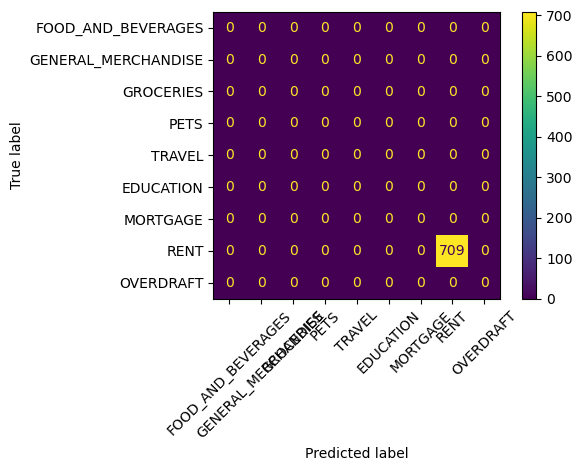

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = y_te.detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()

labels_idx = np.arange(len(outflow_test['category'].unique()))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

plt.figure(figsize=(20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=outflow_test['category'].unique())
disp.plot(xticks_rotation=45, colorbar=True)
plt.tight_layout()
plt.show()